In [1]:
import os
from pathlib import Path

from src import dino


# Output directory (_output is ignored by git)
OUTPUT_DIR = "_output"
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    print("Created output directory:", OUTPUT_DIR)


IMAGE_DIR = Path("images/egsr_illusions")
def file_to_brightness(file_path, model, white_nits=200):
    image = dino.read_image(file_path)
    L = dino.rgb_to_relative_luminance(image)
    L *= white_nits
    return model(L)

  0%|          | 0/5 [00:00<?, ?it/s]

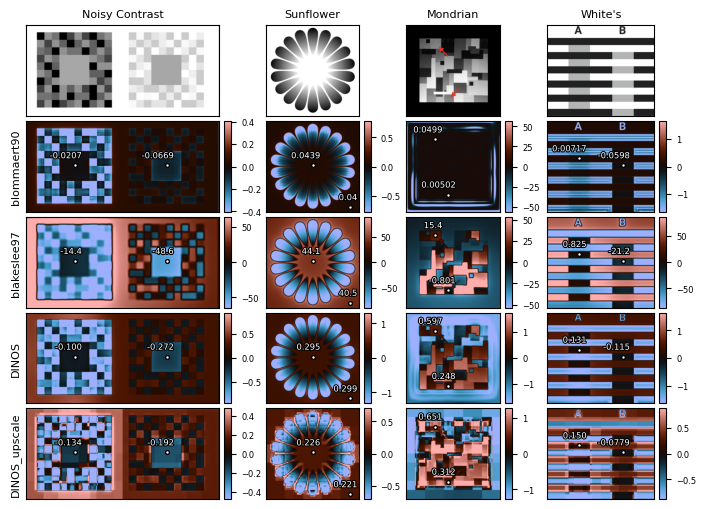

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import Normalize
from matplotlib.patheffects import withStroke
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm.auto import tqdm


IMAGE_POINTS_OF_INTEREST = [
    (
        "Noisy Contrast",
        "noisy_contrast.png",
        [(345, 315), (1005, 315)],
    ),
    (
        "Sunflower",
        "sunflower1.png",
        [(600, 615), (335, 315)],
    ),
    (
        "Mondrian",
        "mondrian1.png",
        [(210, 130), (305, 525)],
    ),
    (
        "White's",
        "whites.png",
        [(230, 265), (540, 315)],
    ),
]
MODELS = [
    ("blommaert90", dino.blommaert_brightness_model),
    ("blakeslee97", dino.blakeslee97_brightness_model),
    ("DINOS", dino.dinos_efficient),
    ("DINOS_upscale", dino.dinos_upscale_only),
]

fig = plt.figure()
nrows = 1 + len(MODELS)
ncols = len(IMAGE_POINTS_OF_INTEREST)
label_font_size = 8
number_font_size = 6
grid = ImageGrid(
    fig,
    (0, 0, 1, 1),
    nrows_ncols=(nrows, ncols),
    axes_pad=(0.35, 0.05),
    cbar_location="right",
    cbar_mode="each",
    cbar_size=0.07,
    cbar_pad=0.05,
)


for row in tqdm(range(nrows)):
    for col, (title, image, pois) in enumerate(IMAGE_POINTS_OF_INTEREST):
        idx = row * ncols + col
        ax = grid[idx]
        cax = grid.cbar_axes[idx]
        image_path = IMAGE_DIR / image
        if row == 0:
            ax.set_title(title, fontsize=label_font_size)
            original_img = mpimg.imread(image_path)
            ax.imshow(original_img, cmap="Greys", aspect="auto")
            cax.axis("off")
        else:
            name, model = MODELS[row-1]
            if col == 0:
                ax.set_ylabel(name, fontsize=label_font_size)
            
            brightness = file_to_brightness(str(image_path), model)
            vrange = max(np.abs(np.percentile(brightness, 90)), np.abs(np.percentile(brightness, 10)))
            norm = Normalize(vmin=-vrange, vmax=vrange, clip=True)
            im = ax.imshow(brightness, cmap="berlin", norm=norm)
            cbar = cax.colorbar(im, norm=norm)
            cax.tick_params(axis="y", labelsize=6)
            for px, py in pois:
                ax.scatter(px, py, marker=".", c="white", s=30, edgecolors="black")
                text = ax.text(
                    px+50,
                    py-50,
                    np.format_float_positional(brightness[py,px], precision=3, unique=False, fractional=False),
                    color="white",
                    fontsize=number_font_size,
                    horizontalalignment="right",
                )
                text.set_path_effects([withStroke(linewidth=1.5, foreground="k")])
    
for ax in grid:
    ax.set_xticks([])
    ax.set_yticks([])

fig.savefig("_output/brightness_illusions_efficient.pdf", dpi=1200, bbox_inches="tight")

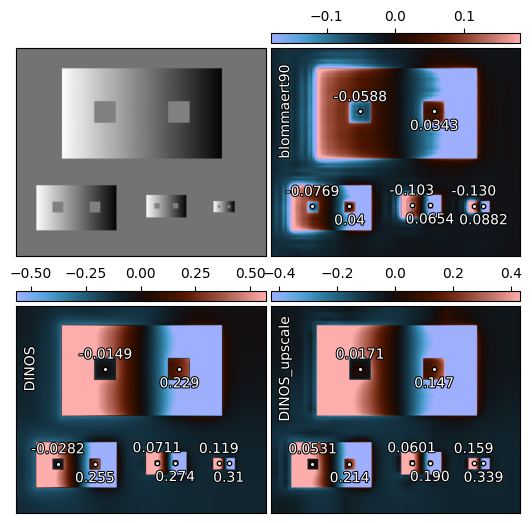

In [ ]:
MODELS = [
    ("blommaert90", dino.blommaert_brightness_model),
    ("DINOS", dino.dinos_efficient),
    ("DINOS_upscale", dino.dinos_upscale_only),
]

multiscale_image_path = IMAGE_DIR / "ramp_squares_cropped.png"
pois = [
    (465, 330), (850, 330),
    (217, 823), (410, 823),
    (733, 817), (828, 817),
    (1056, 821), (1107, 821),
]
fig = plt.figure()
nrows = 2
ncols = 2
label_font_size = 10
grid = ImageGrid(
    fig,
    (0, 0, 1, 1),
    nrows_ncols=(nrows, ncols),
    axes_pad=(0.05, 0.35),
    cbar_location="top",
    cbar_mode="each",
    cbar_size=0.1,
    cbar_pad=0.05,
)

original_img = mpimg.imread(multiscale_image_path)
grid[0].imshow(original_img, cmap="Greys", aspect="auto")
grid.cbar_axes[0].axis("off")
for ax, cax, (name, model) in zip(grid[1:], grid.cbar_axes[1:], MODELS, strict=True):
    brightness = file_to_brightness(str(multiscale_image_path), model)
    vrange = max(np.abs(np.percentile(brightness, 90)), np.abs(np.percentile(brightness, 10)))
    norm = Normalize(vmin=-vrange, vmax=vrange, clip=True)
    im = ax.imshow(brightness, cmap="berlin", norm=norm)
    cbar = cax.colorbar(im, norm=norm)
    texts = []
    for i, (px, py) in enumerate(pois):
        ax.scatter(px, py, marker=".", c="white", s=40, edgecolors="black")
        offset_py = 75
        if i % 2 == 0:
            offset_py = -offset_py
        text = ax.text(
            px,
            py+offset_py,
            np.format_float_positional(brightness[py,px], precision=3, unique=False, fractional=False),
            color="white",
            fontsize=label_font_size,
            horizontalalignment="center",
            verticalalignment="center",
        )
        texts.append(text)
    texts.append(
        ax.text(
            75, 330, name,
            color="white",
            fontsize=label_font_size,
            horizontalalignment="center",
            verticalalignment="center",
            rotation=90,
        )
    )
    for text in texts:
        text.set_path_effects([withStroke(linewidth=1.5, foreground="k")])

for ax in grid:
    ax.set_xticks([])
    ax.set_yticks([])

fig.savefig("_output/multiscale_illusion.pdf", dpi=1200, bbox_inches="tight")

In [ ]:
from src import plotting

## Apply model to all illusions
ILLUSION_IMAGES = [
    "noisy_contrast.png",
    "sunflower1.png",
    "mondrian1.png",
    "whites.png",
]

for image in ILLUSION_IMAGES:
    for name, model in [
        ("dinos", dino.dn_brightness_model),
        ("blakeslee97", dino.blakeslee97_brightness_model),
        ("blommaert", dino.blommaert_brightness_model),
    ]:
        brightness = file_to_brightness(str(IMAGE_DIR / image), model)
        filename = f"{os.path.splitext(image)[0]}_{name}.html"
        filepath = os.path.join(OUTPUT_DIR, filename)
        plotting.image_height_plot(
            brightness,
            output_path=filepath,
            display=False,
        )
        print("Exported", filepath)

Exported _output/noisy_contrast_dinos.html
Exported _output/noisy_contrast_blakeslee97.html
Exported _output/noisy_contrast_blommaert.html
Exported _output/sunflower1_dinos.html
Exported _output/sunflower1_blakeslee97.html
Exported _output/sunflower1_blommaert.html
Exported _output/mondrian1_dinos.html
Exported _output/mondrian1_blakeslee97.html
Exported _output/mondrian1_blommaert.html
Exported _output/whites_dinos.html
Exported _output/whites_blakeslee97.html
Exported _output/whites_blommaert.html
